# Week 2: Tackle Overfitting with Data Augmentation

In [1]:
# Disable Warnings
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

In [2]:
# Import Libraries
import os
import zipfile
import random
import shutil
import tensorflow as tf
from shutil import copyfile
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop

2024-07-04 10:30:10.635124: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-04 10:30:10.635178: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-04 10:30:10.636667: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# If the URL doesn't work, visit https://www.microsoft.com/en-us/download/confirmation.aspx?id=54765
# And right click on the 'Download Manually' link to get a new URL to the dataset

# Note: This is a very large dataset and will take some time to download

!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip" \
    -O "/tmp/cats-and-dogs.zip"

local_zip = '/tmp/cats-and-dogs.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

--2024-07-04 10:30:14--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.193.24.207, 2600:1417:76:585::317f, 2600:1417:76:581::317f
Connecting to download.microsoft.com (download.microsoft.com)|23.193.24.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: '/tmp/cats-and-dogs.zip'

/tmp/cats-and-dogs. 100%[===================>] 786.67M   184MB/s    in 4.5s    

2024-07-04 10:30:19 (175 MB/s) - '/tmp/cats-and-dogs.zip' saved [824887076/824887076]



In [4]:
# grader-required-cell

source_path = '/tmp/PetImages'

source_path_dogs = os.path.join(source_path, 'Dog')
source_path_cats = os.path.join(source_path, 'Cat')

# Deletes all non-image files (there are two .db files bundled into the dataset)
!find /tmp/PetImages/ -type f ! -name "*.jpg" -exec rm {} +

# os.listdir returns a list containing all files under the given path
print(f"There are {len(os.listdir(source_path_dogs))} images of dogs.")
print(f"There are {len(os.listdir(source_path_cats))} images of cats.")

There are 12500 images of dogs.
There are 12500 images of cats.


In [5]:
# grader-required-cell

# Define root directory
root_dir = '/tmp/cats-v-dogs'

# Empty directory to prevent FileExistsError is the function is run several times
if os.path.exists(root_dir):
  shutil.rmtree(root_dir)

# GRADED FUNCTION: create_train_val_dirs
def create_train_val_dirs(root_path):
    os.makedirs(os.path.join(root_path, 'training'))
    os.makedirs(os.path.join(f"{root_path}/training", "dogs"))
    os.makedirs(os.path.join(f"{root_path}/training", "cats"))
    os.makedirs(os.path.join(root_path, 'testing'))
    os.makedirs(os.path.join(f"{root_path}/testing", 'dogs'))
    os.makedirs(os.path.join(f"{root_path}/testing",'cats'))

  ### START CODE HERE
    

  # HINT:
  # Use os.makedirs to create your directories with intermediate subdirectories
  # Don't hardcode the paths. Use os.path.join to append the new directories to the root_path parameter

  

  ### END CODE HERE

  
try:
  create_train_val_dirs(root_path=root_dir)
except FileExistsError:
  print("You should not be seeing this since the upper directory is removed beforehand")

In [6]:
# grader-required-cell

# Test your create_train_val_dirs function

for rootdir, dirs, files in os.walk(root_dir):
    for subdir in dirs:
        print(os.path.join(rootdir, subdir))

/tmp/cats-v-dogs/testing
/tmp/cats-v-dogs/training
/tmp/cats-v-dogs/testing/cats
/tmp/cats-v-dogs/testing/dogs
/tmp/cats-v-dogs/training/cats
/tmp/cats-v-dogs/training/dogs


In [7]:
# grader-required-cell

# Test your create_train_val_dirs function

for rootdir, dirs, files in os.walk(root_dir):
    for subdir in dirs:
        print(os.path.join(rootdir, subdir))

/tmp/cats-v-dogs/testing
/tmp/cats-v-dogs/training
/tmp/cats-v-dogs/testing/cats
/tmp/cats-v-dogs/testing/dogs
/tmp/cats-v-dogs/training/cats
/tmp/cats-v-dogs/training/dogs


In [8]:
# grader-required-cell

# GRADED FUNCTION: split_data
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):

  ### START CODE HERE
  # Shuffle list
  shuffled_source = random.sample(os.listdir(SOURCE), len(os.listdir(SOURCE)))

  # Find total number of files in training dir
  training_number = int(len(shuffled_source) * SPLIT_SIZE)

  i = 0
  target = TRAINING

  for item in shuffled_source:
    item_source = os.path.join(SOURCE, item)
    if os.path.getsize(item_source) == 0:
      print(f'{item} is zero length, so ignoring.')
    else: 
      copyfile(item_source, os.path.join(target, item))
      i += 1

    # Switch copy target to TESTING
    if i == training_number:
      target = TESTING
  ### END CODE HERE

In [9]:
# Test your split_data function

# Define paths
CAT_SOURCE_DIR = "/tmp/PetImages/Cat/"
DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"

TRAINING_DIR = "/tmp/cats-v-dogs/training/"
TESTING_DIR = "/tmp/cats-v-dogs/testing/"

TRAINING_CATS_DIR = os.path.join(TRAINING_DIR, "cats/")
TESTING_CATS_DIR = os.path.join(TESTING_DIR, "cats/")

TRAINING_DOGS_DIR = os.path.join(TRAINING_DIR, "dogs/")
TESTING_DOGS_DIR = os.path.join(TESTING_DIR, "dogs/")

# Empty directories in case you run this cell multiple times
if len(os.listdir(TRAINING_CATS_DIR)) > 0:
  for file in os.scandir(TRAINING_CATS_DIR):
    os.remove(file.path)
if len(os.listdir(TRAINING_DOGS_DIR)) > 0:
  for file in os.scandir(TRAINING_DOGS_DIR):
    os.remove(file.path)
if len(os.listdir(TESTING_CATS_DIR)) > 0:
  for file in os.scandir(TESTING_CATS_DIR):
    os.remove(file.path)
if len(os.listdir(TESTING_DOGS_DIR)) > 0:
  for file in os.scandir(TESTING_DOGS_DIR):
    os.remove(file.path)

# Define proportion of images used for training
split_size = .9

# Run the function
# NOTE: Messages about zero length images should be printed out
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)

# Your function should perform copies rather than moving images so original directories should contain unchanged images
print(f"\n\nOriginal cat's directory has {len(os.listdir(CAT_SOURCE_DIR))} images")
print(f"Original dog's directory has {len(os.listdir(DOG_SOURCE_DIR))} images\n")

# Check that the number of images matches the expected output
print(f"\n\nThere are {len(os.listdir(TRAINING_CATS_DIR))} images of cats for training")
print(f"There are {len(os.listdir(TRAINING_DOGS_DIR))} images of dogs for training")
print(f"There are {len(os.listdir(TESTING_CATS_DIR))} images of cats for testing")
print(f"There are {len(os.listdir(TESTING_DOGS_DIR))} images of dogs for testing")

666.jpg is zero length, so ignoring.
11702.jpg is zero length, so ignoring.


Original cat's directory has 12500 images
Original dog's directory has 12500 images



There are 11250 images of cats for training
There are 11250 images of dogs for training
There are 1249 images of cats for testing
There are 1249 images of dogs for testing


In [10]:
# GRADED FUNCTION: train_val_generators
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):
#     train_datagen = ImageDataGenerator(rescale = 1.0/255)
      # Instantiate the ImageDataGenerator class (don't forget to set the arguments to augment the images)
    train_datagen = ImageDataGenerator(rescale=1.0/255,
                                     rotation_range=40,
                                     width_shift_range=0.3,
                                     height_shift_range=0.3,
                                     shear_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     fill_mode='nearest')
  ### START CODE HERE
    train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=40,
                                                      class_mode='binary',
                                                      target_size=(150, 150))

  # Instantiate the ImageDataGenerator class (don't forget to set the rescale argument)
    validation_datagen = ImageDataGenerator(rescale=1./255.)

  # Pass in the appropriate arguments to the flow_from_directory method
    validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                batch_size=5,
                                                                class_mode='binary',
                                                                target_size=(150, 150))
  ### END CODE HERE
    return train_generator, validation_generator

In [11]:
# Test your generators
train_generator, validation_generator = train_val_generators(TRAINING_DIR, TESTING_DIR)

Found 22500 images belonging to 2 classes.
Found 2498 images belonging to 2 classes.


In [12]:
# grader-required-cell

# GRADED FUNCTION: create_model
def create_model():
    
  # DEFINE A KERAS MODEL TO CLASSIFY CATS V DOGS
  # USE AT LEAST 3 CONVOLUTION LAYERS

  ### START CODE HERE
    model = tf.keras.models.Sequential([ 
      tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150,150,3)),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
  ])


    model.compile(optimizer=RMSprop(learning_rate=0.001),
                    loss='binary_crossentropy',
                    metrics=['accuracy']) 

      ### END CODE HERE

    return model

In [13]:
# Get the untrained model
model = create_model()

In [14]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 5, 5, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 238,913 (933.25 KB)

 Trainable params: 238,913 (933.25 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# Train the model
# Note that this may take some time.
history = model.fit(train_generator,
                    epochs=15,
                    verbose=1,
                    validation_data=validation_generator)

Epoch 1/15


2024-07-04 10:30:46.312913: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 43808: 6.55054, expected 5.62687
2024-07-04 10:30:46.312965: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 43810: 6.35291, expected 5.42923
2024-07-04 10:30:46.312975: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 43811: 7.90706, expected 6.98338
2024-07-04 10:30:46.312983: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 43812: 7.37887, expected 6.4552
2024-07-04 10:30:46.312990: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 43814: 7.81369, expected 6.89002
2024-07-04 10:30:46.312999: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 43815: 8.21973, expected 7.29606
2024-07-04 10:30:46.313007: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 43816: 6.36164, expected 5.43797
2024-07-04 10:30:46.313014: 

  1/563 ━━━━━━━━━━━━━━━━━━━━ 1:04:14 7s/step - accuracy: 0.4750 - loss: 0.6926

I0000 00:00:1720089049.183155     953 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 69/563 ━━━━━━━━━━━━━━━━━━━━ 2:00 243ms/step - accuracy: 0.5128 - loss: 0.6939

2024-07-04 10:31:06.328299: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 43839: 5.63082, expected 4.95217
2024-07-04 10:31:06.328349: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 43865: 5.44907, expected 4.77042
2024-07-04 10:31:06.328359: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 43984: 5.70117, expected 5.02252
2024-07-04 10:31:06.328367: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 44038: 5.62458, expected 4.94592
2024-07-04 10:31:06.328377: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 44411: 5.30065, expected 4.62199
2024-07-04 10:31:06.328385: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 44559: 5.21467, expected 4.53602
2024-07-04 10:31:06.328393: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 44560: 5.74743, expected 5.06877
2024-07-04 10:31:06.328401:

562/563 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.5563 - loss: 0.6800

2024-07-04 10:33:03.004192: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 87616: 6.64307, expected 5.79537
2024-07-04 10:33:03.004239: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 87617: 6.9075, expected 6.05979
2024-07-04 10:33:03.004249: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 87618: 7.21559, expected 6.36789
2024-07-04 10:33:03.004257: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 87622: 7.41938, expected 6.57167
2024-07-04 10:33:03.004265: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 87623: 6.23928, expected 5.39157
2024-07-04 10:33:03.004273: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 87624: 5.78781, expected 4.9401
2024-07-04 10:33:03.004281: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 87625: 5.74241, expected 4.89471
2024-07-04 10:33:03.004289: E

563/563 ━━━━━━━━━━━━━━━━━━━━ 146s 247ms/step - accuracy: 0.5564 - loss: 0.6800 - val_accuracy: 0.6433 - val_loss: 0.6306
Epoch 2/15
563/563 ━━━━━━━━━━━━━━━━━━━━ 136s 239ms/step - accuracy: 0.6172 - loss: 0.6481 - val_accuracy: 0.6926 - val_loss: 0.5799
Epoch 3/15
563/563 ━━━━━━━━━━━━━━━━━━━━ 135s 238ms/step - accuracy: 0.6471 - loss: 0.6241 - val_accuracy: 0.5965 - val_loss: 0.6799
Epoch 4/15
563/563 ━━━━━━━━━━━━━━━━━━━━ 135s 237ms/step - accuracy: 0.6703 - loss: 0.6103 - val_accuracy: 0.7330 - val_loss: 0.5482
Epoch 5/15
563/563 ━━━━━━━━━━━━━━━━━━━━ 136s 238ms/step - accuracy: 0.6755 - loss: 0.6000 - val_accuracy: 0.7290 - val_loss: 0.5434
Epoch 6/15
563/563 ━━━━━━━━━━━━━━━━━━━━ 138s 242ms/step - accuracy: 0.6736 - loss: 0.6036 - val_accuracy: 0.7154 - val_loss: 0.5560
Epoch 7/15
563/563 ━━━━━━━━━━━━━━━━━━━━ 136s 239ms/step - accuracy: 0.6860 - loss: 0.5956 - val_accuracy: 0.7202 - val_loss: 0.5462
Epoch 8/15
563/563 ━━━━━━━━━━━━━━━━━━━━ 137s 240ms/step - accuracy: 0.6976 - loss: 0.58

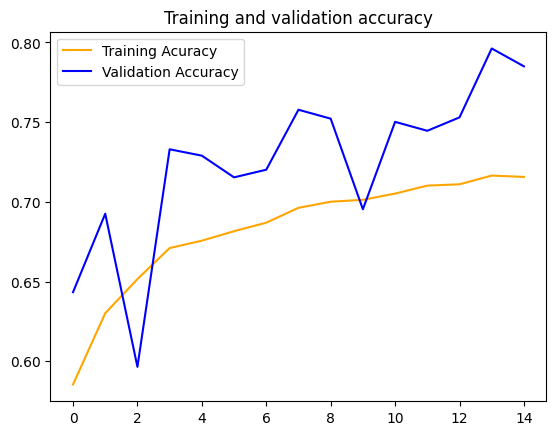

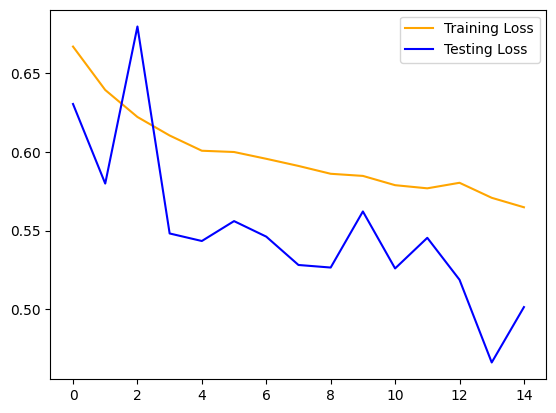

In [24]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'orange', label='Training Acuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()
print("")

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'orange', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Testing Loss')
plt.legend()
plt.show()